In [1]:
import itertools

import numpy as np  # pip install numpy
import scipy.stats  # pip install scipy

import pandas as pd  # pip install pandas
import matplotlib.pyplot as plt  # pip install matplotlib
import seaborn as sns  # pip install seaborn

sns.set_context("notebook")
sns.set_style("whitegrid")

FIG_SIZE = (14, 4)

# Loading Datasets

In [2]:
video_quality = pd.read_excel("../datasets/DB01_gaming_video_quality_dataset.xlsx")
speech_quality = pd.read_excel("../datasets/DB02_speaker_likeability_quality_ratings.xlsx")

display(video_quality.head(3))
display(speech_quality.head(3))

,PID,Game,Condition,Condition_params,Resolution,Framerate,Bitrate,VQ,VF,VU,VD,AC,Age,Gender,Expertise,Monitor
0,1,Game1,15,480_30_300,480,30,300,1.4,1.3,1.6,5.7,0,21.0,Male,4.0,Desktop
1,2,Game1,15,480_30_300,480,30,300,1.2,1.2,4.6,6.3,0,20.0,Female,1.0,Desktop
2,3,Game1,15,480_30_300,480,30,300,2.5,2.3,2.8,4.4,0,NaN,NaN,NaN,NaN


,PID,Gender,Age,Filename,MOS
0,1,w,29,m041_bucharest_d1_1a1b_IRS_NB_AMRNB_4_75.wav,3.356023
1,2,w,29,m041_bucharest_d1_1a1b_IRS_NB_AMRNB_4_75.wav,2.286674
2,3,w,31,m041_bucharest_d1_1a1b_IRS_NB_AMRNB_4_75.wav,2.995900


# Exercise 1

### Calculate all available bitrate-framerate pairs and assign a color

Available games: ['Game1' 'Game2' 'Game3' 'Game4' 'Game5' 'Game6']
Available bitrates: [  300  1000  2000  4000  6000 50000]
Available framerates: [30 60]
Color palette:


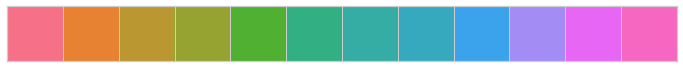

{(300, 30): (0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (300, 60): (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (1000, 30): (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (1000, 60): (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (2000, 30): (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (2000, 60): (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (4000, 30): (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (4000, 60): (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (6000, 30): (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (6000, 60): (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (50000, 30): (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (50000, 60): (0.9633321742064956, 0.40643825645731757, 0.7592537599568671)}

In [3]:
all_game_names = video_quality.Game.unique()
all_game_names.sort()
print(f"Available games: {all_game_names}")

all_bitrates = video_quality.Bitrate.unique()
all_bitrates.sort()
print(f"Available bitrates: {all_bitrates}")

all_framerates = video_quality.Framerate.unique()
all_framerates.sort()
print(f"Available framerates: {all_framerates}")

pairs = tuple(itertools.product(all_bitrates, all_framerates))

print("Color palette:")
color_palette = sns.color_palette("husl", len(pairs))
sns.palplot(color_palette)
plt.show()

pair_colors = dict(zip(pairs, color_palette))
display(pair_colors)

## Matplotlib version
### Define function to calculate mean point estimate and confidence interval

In [4]:
def mean_confidence_interval(data: pd.Series, confidence: float = 0.95):
    """https://stackoverflow.com/a/15034143"""
    n = len(data)
    mean = np.mean(data)
    std_err_of_measurement = scipy.stats.sem(data)
    confidence = std_err_of_measurement * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return pd.Series(
        [mean, confidence],
        name="statistics",
        index=["mean", "confidence"]
    )

### Generate plots

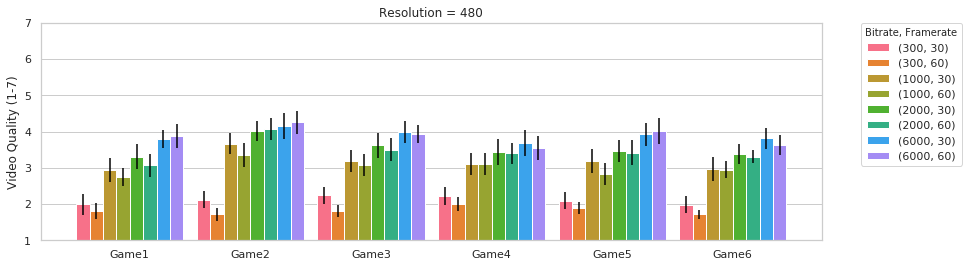

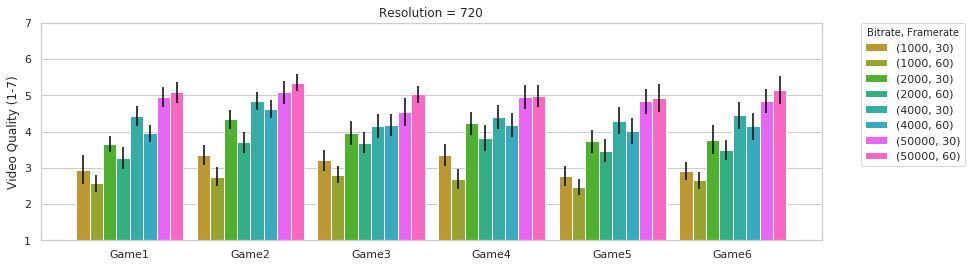

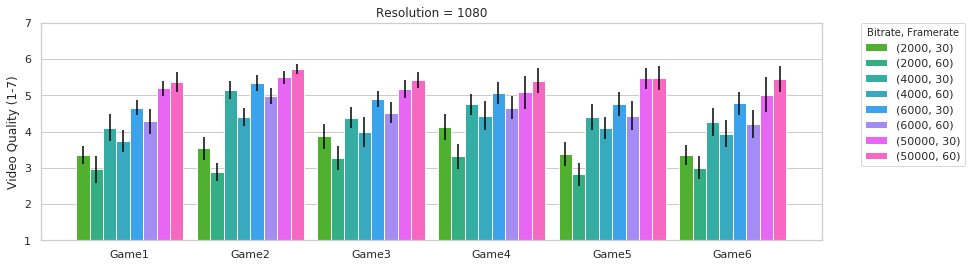

In [5]:
# Manually iterate over groupby to create separate figures
for resolution, resolution_data in video_quality.groupby(by="Resolution"):
    fig, ax = plt.subplots(figsize=FIG_SIZE)
    ax.set_title(f"Resolution = {resolution}")
    ax.set_ylim([1, 7])  # VQ scale starts at 1, not at 0
    ax.set_ylabel("Video Quality (1-7)")
    ax.xaxis.grid(False)  # x value does not have meaning, turn off x-grid
    
    # Create single groupby for game and bitrate to avoid unnecessary looping
    grouped_by_game_bitrate = resolution_data.groupby(by=["Game", "Bitrate", "Framerate"])
    statistics = grouped_by_game_bitrate.VQ.apply(mean_confidence_interval)
    
    # Extract xticks and legend labels
    games = statistics.index.levels[0]  # xticks labels
    bitrates = statistics.index.levels[1]  # legend labels
    framerates = statistics.index.levels[2]  # legend labels
    br_fr_pairs = tuple(itertools.product(bitrates, framerates))
    
    num_groups = len(games)
    num_bars = len(br_fr_pairs)
    
    # One group has a total width of 1. Groups are spaced with one bar width.
    # Therefore, the bar width is:
    bar_width = 1 / (num_bars + 1)

    # Each group starts at an interger location: 0, 1, 2, 3, ...
    group_loc = np.arange(num_groups)
    for idx, (bitrate, framerate) in enumerate(br_fr_pairs):
        # For each bar in a given game, we add one bar_width offset
        bar_loc = group_loc + idx * bar_width
        
        # Extract statistics
        bar_mean = statistics[:, bitrate, framerate, "mean"]
        bar_confidence = statistics[:, bitrate, framerate, "confidence"]

        # Plot bars
        color = pair_colors[(bitrate, framerate)]
        plt.bar(bar_loc, bar_mean, yerr=bar_confidence, width=bar_width, color=color)

    # Center xticks
    xticks_loc = group_loc + bar_width * (num_bars - 1) / 2
    plt.xticks(xticks_loc, games)

    # Add legend outside of figure
    plt.legend(
        br_fr_pairs,
        title="Bitrate, Framerate",
        bbox_to_anchor=(1.05, 1),
        loc=2,
        borderaxespad=0.0,
    )

## Seaborn version

**Note:** This solution does not fully satisfy the exercise!

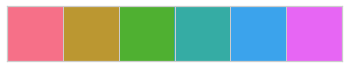

In [6]:
game_names = video_quality.Game.unique()
game_names.sort()

bitrates = video_quality.Bitrate.unique()
bitrates.sort()

bitrate_colors = sns.color_palette("husl", len(bitrates))
sns.palplot(bitrate_colors)
bitrate_colors = dict(zip(bitrates, bitrate_colors))

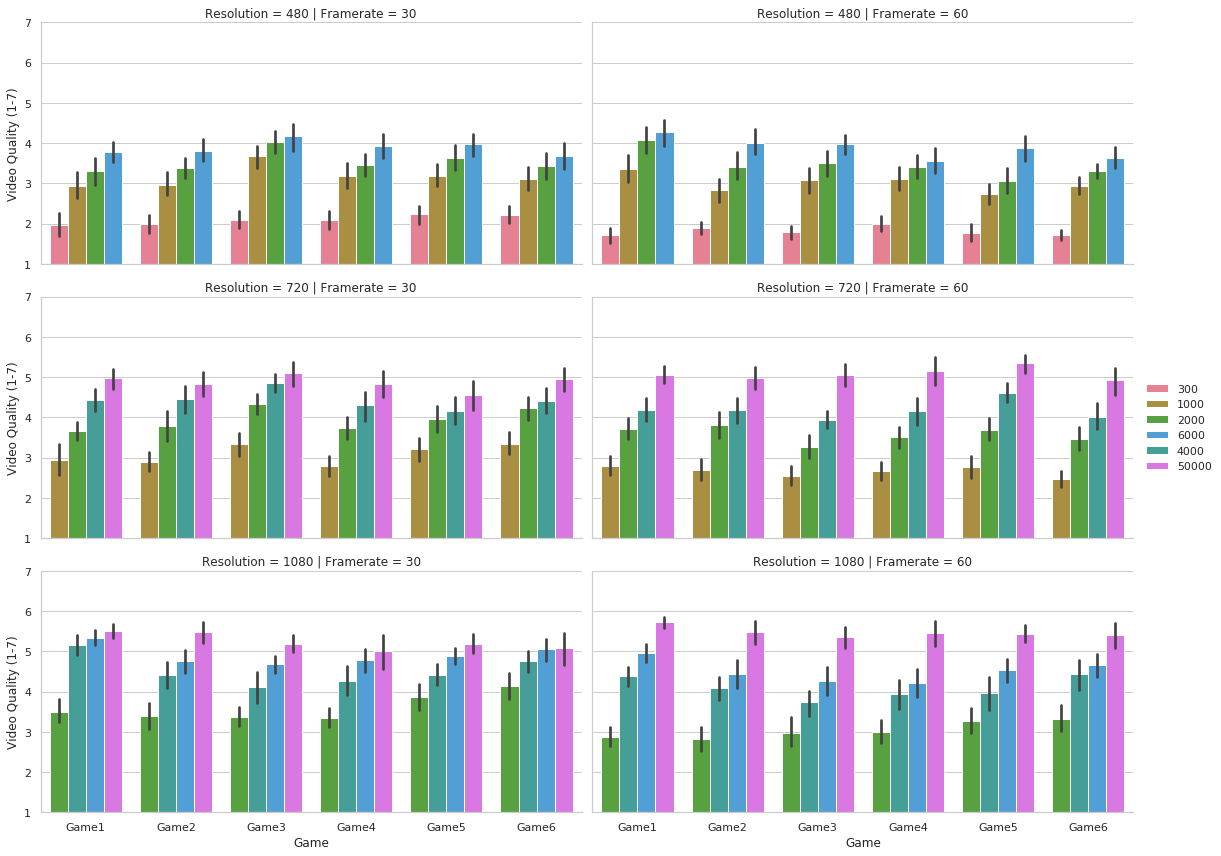

In [7]:
fg = sns.FacetGrid(
    data=video_quality,
    row="Resolution",
    col="Framerate",
    height=4,
    aspect=2,
    subplot_kws={"ylim": [1, 7]},
)
fg.map_dataframe(sns.barplot, "Game", "VQ", "Bitrate", palette=bitrate_colors)
fg.add_legend()
fg.set_xticklabels(game_names)
fg.set_ylabels("Video Quality (1-7)")

# Exercise 2

## Data selection

In [8]:
video_quality_hierarchal = video_quality.set_index(
    ["Resolution", "Framerate", "Bitrate", "Condition"]
)

resolution = 480
framerate = 30
bitrate = 300
conditions = [15, 43, 66]
video_quality_filtered = video_quality_hierarchal.loc[
    resolution, framerate, bitrate, conditions
]

all_game_names = video_quality_filtered.Game.unique()
all_game_names.sort()

## Matplotlib version

Text(0.5, 1.0, 'Resolution: 480 Framerate: 30 Bitrate: 300 Conditions: [15, 43, 66]')

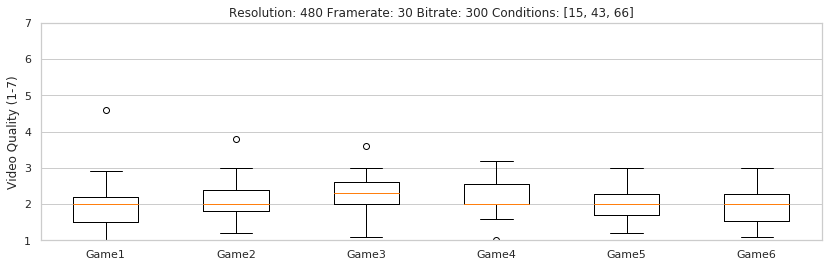

In [9]:
# Group by game, select video quality
vq_by_game = video_quality_filtered.groupby(by="Game").VQ

# Convert to list of vectors, required as plt.boxplot input
vq_by_game_arrays = vq_by_game.apply(np.array)
labels = vq_by_game_arrays.index
values = vq_by_game_arrays.values

# Create figure
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.xaxis.grid(False)

# Plot boxplots
plt.boxplot(x=values, labels=labels)

ax.set_ylim([1,7])
ax.set_ylabel("Video Quality (1-7)")
ax.set_title(f"Resolution: {resolution} Framerate: {framerate} Bitrate: {bitrate} Conditions: {conditions}")

## Seaborn version

Text(0.5, 1.0, 'Resolution: 480 Framerate: 30 Bitrate: 300 Conditions: [15, 43, 66]')

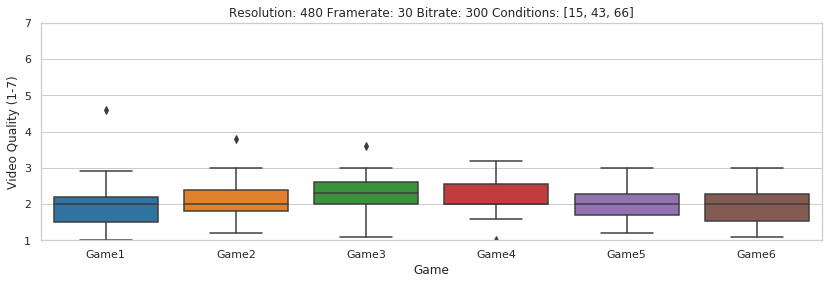

In [10]:
fig, ax = plt.subplots(figsize=FIG_SIZE)
sns.boxplot(
    data=video_quality_filtered,
    x="Game",
    y="VQ",
    order=game_names,
)
ax.set_ylim([1,7])
ax.set_ylabel("Video Quality (1-7)")
ax.set_title(f"Resolution: {resolution} Framerate: {framerate} Bitrate: {bitrate} Conditions: {conditions}")

# Exercise 3

## Data selection

In [11]:
age_dist_by_age = pd.DataFrame(speech_quality.groupby(["Age", "Gender"]).PID.unique())

#Preparing and adding number of participants per age
tmp_list = age_dist_by_age.values.tolist()
anz = [len(elem[0]) for elem in tmp_list]
age_dist_by_age["Anzahl"] = anz

#transforming table
age_dist_by_age = age_dist_by_age.reset_index()
age_dist_by_age = age_dist_by_age.pivot(columns='Gender', index='Age', values=['Anzahl'])
age_dist_by_age = age_dist_by_age.fillna(0)
age_dist_by_age = age_dist_by_age.astype(int, copy=False)

age_dist_by_age

Anzahl   
Gender      m  w
Age             
19          1  0
21          0  1
22          2  0
23          1  2
24          0  1
25          1  0
27          1  1
28          1  1
29          0  3
31          1  1
32          1  0
34          1  0

## Matplotlib version

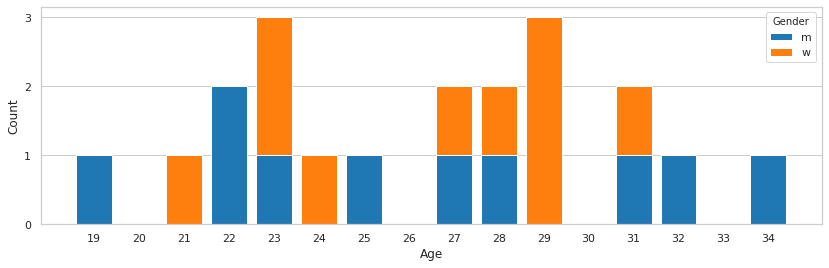

In [12]:
x = age_dist_by_age.index
male = age_dist_by_age.Anzahl.m
female = age_dist_by_age.Anzahl.w

fig, ax = plt.subplots(figsize=FIG_SIZE)

plt.bar(x, male, label="m")
# Call bottom with .tolist() to avoid weird TypeError...
plt.bar(x, female, bottom=male.tolist(), label="w")
plt.legend(title="Gender")

#show every number on x axis and only ganze Zahlen on y axis
plt.xticks(np.arange(min(list(x)), max(list(x)) + 1, 1))
plt.yticks(np.arange(0, max(max(male), max(female)) + 1, 1))

ax.set_ylabel("Count")
ax.set_xlabel("Age")
ax.xaxis.grid(False)